In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras_nlp.layers import PositionEmbedding

In [32]:
seed = 428

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [33]:
def bert_module(query, key, value, embed_dim, num_head, i):
    
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_head,
        key_dim=embed_dim // num_head,
        name="encoder_{}/multiheadattention".format(i)
    )(query, key, value, use_causal_mask=True)
    
    # Add & Normalize
    attention_output = layers.Add()([query, attention_output])  # Skip Connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feedforward network
    ff_net = keras.models.Sequential([
        layers.Dense(2 * embed_dim, activation='relu', name="encoder_{}/ffn_dense_1".format(i)),
        layers.Dense(embed_dim, name="encoder_{}/ffn_dense_2".format(i)),
    ])

    # Apply Feedforward network
    ffn_output = ff_net(attention_output)

    # Add & Normalize
    ffn_output = layers.Add()([attention_output, ffn_output])  # Skip Connection
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn_output)
    
    return ffn_output

In [34]:
def get_sinusoidal_embeddings(sequence_length, embedding_dim):
    position_enc = np.array([
        [pos / np.power(10000, 2. * i / embedding_dim) for i in range(embedding_dim)]
        if pos != 0 else np.zeros(embedding_dim)
        for pos in range(sequence_length)
    ])
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])  # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])  # dim 2i+1
    return tf.cast(position_enc, dtype=tf.float32)

In [35]:
def insert_element_randomly(my_list, element):
    
    if len(my_list) > 1:

        index = random.randint(0, 2)
        
    else:
        
        index = 0

    new_list = my_list[:(4 * index)] + element + my_list[(4 * index):]
    
    return new_list

In [36]:
N = 20 # vocab_size
M = 20 # number of random words

vocabs = ['word_' + str(i) for i in range(N)] + ['random_' + str(i) for i in range(M)]

vocabs_word = ['word_' + str(i) for i in range(N)]

vocab_map = {}
for i in range(len(vocabs)):
    vocab_map[vocabs[i]] = i

In [37]:
pairs = []

for i in vocabs_word:
    for j in vocabs_word:
        for k in vocabs_word:
            if i != j and i != k and j != k:
                pairs.append((i,j,k))

indicator = np.random.choice([0, 1], size=len(pairs), p=[0.5, 0.5])

pairs_train = [pairs[i] for i in range(len(indicator)) if indicator[i] == 1]
pairs_test = [pairs[i] for i in range(len(indicator)) if indicator[i] == 0]

sentences_train = []
sentences_number_train = []
sentences_test_a = []
sentences_number_test_a = []
sentences_test_b = []
sentences_number_test_b = []

x_masked_train = []
y_masked_labels_train = []
x_masked_test_a = []
y_masked_labels_test_a = []
x_masked_test_b = []
y_masked_labels_test_b = []

for _ in range(25000):

    random_words = random.sample(['random_' + str(i) for i in range(M)], 4)

    [(a,b,c), (d,e,f)] = random.sample(pairs_train, 2)

    temp = [a, b, c, a, d, e, f, d]
    temp = insert_element_randomly(temp, random_words)

    sentences_train.append(temp)
    sentences_number_train.append([vocab_map[i] for i in temp])
    x_masked_train.append([vocab_map[i] for i in temp])
    y_masked_labels_train.append([vocab_map[i] for i in temp][1:])

    random_words = random.sample(['random_' + str(i) for i in range(M)], 4)

    [(a,b,c), (d,e,f)] = random.sample(pairs_train, 2)

    temp = [a, b, c, b, d, e, f, e]
    temp = insert_element_randomly(temp, random_words)

    sentences_train.append(temp)
    sentences_number_train.append([vocab_map[i] for i in temp])
    x_masked_train.append([vocab_map[i] for i in temp])
    y_masked_labels_train.append([vocab_map[i] for i in temp][1:])



for _ in range(25000):

    [(a,b,c), (d,e,f), (g,h,i)] = random.sample(pairs_test, 3)

    temp = [a, b, c, a, d, e, f, d, g, h, i, g]

    sentences_test_a.append(temp)
    sentences_number_test_a.append([vocab_map[i] for i in temp])
    x_masked_test_a.append([vocab_map[i] for i in temp])
    y_masked_labels_test_a.append([vocab_map[i] for i in temp][1:])

    [(a,b,c), (d,e,f), (g,h,i)] = random.sample(pairs_test, 3)

    temp = [a, b, c, b, d, e, f, e, g, h, i, h]

    sentences_test_b.append(temp)
    sentences_number_test_b.append([vocab_map[i] for i in temp])
    x_masked_test_b.append([vocab_map[i] for i in temp])
    y_masked_labels_test_b.append([vocab_map[i] for i in temp][1:])

x_masked_train = np.array(x_masked_train)
y_masked_labels_train = np.array(y_masked_labels_train)
x_masked_test_a = np.array(x_masked_test_a)
y_masked_labels_test_a = np.array(y_masked_labels_test_a)
x_masked_test_b = np.array(x_masked_test_b)
y_masked_labels_test_b = np.array(y_masked_labels_test_b)

perm = np.random.permutation(len(x_masked_train))
x_masked_train = x_masked_train[perm]
y_masked_labels_train = y_masked_labels_train[perm]

x_masked_train = x_masked_train[:,:-1]
x_masked_test_a = x_masked_test_a[:,:-1]
x_masked_test_b = x_masked_test_b[:,:-1]

In [38]:
x_masked_train[0]

array([22, 37, 38, 32, 15, 17,  4, 17, 11,  3,  6])

In [39]:
y_masked_labels_train[0]

array([37, 38, 32, 15, 17,  4, 17, 11,  3,  6,  3])

In [40]:
# Building the model

embed_dim = 100
num_heads = 2
num_blocks = 1

batch_size = 1024

input_layer = layers.Input(shape=(x_masked_train.shape[1],), dtype=tf.int32)  # Input layer

embedding_layer = layers.Embedding(M + N, embed_dim, name="word_embedding")(input_layer)  # Embedding layer
position_embeddings = PositionEmbedding(sequence_length=len(x_masked_train[0]))(embedding_layer)
embedding_layer = embedding_layer + position_embeddings

# Transformer blocks with causal masking for next token prediction
x = embedding_layer
for i in range(num_blocks):
    # Apply the causal mask to ensure that each position can only attend to known tokens
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x, x, use_causal_mask=True)
    
    x = layers.Add()([x, attention_output])  # Skip Connection
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    ff_net = keras.models.Sequential([
        layers.Dense(2 * embed_dim, activation='relu'),
        layers.Dense(embed_dim),
    ])

    # Apply Feedforward network
    x = ff_net(x)

    # Add & Normalize
    x = layers.Add()([attention_output, x]) 
    x = layers.LayerNormalization(epsilon=1e-6)(x)

# Output layer for providing predictions over the vocabulary
predict_layer = layers.Dense(M + N, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=predict_layer)  # Model definition
model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model

# Reshape the target data to have an extra dimension
y_masked_labels_train_reshaped = y_masked_labels_train.reshape(y_masked_labels_train.shape[0], 
                                                               y_masked_labels_train.shape[1], 1)

In [41]:
x_test_subset_a = x_masked_test_a[np.random.choice(x_masked_test_a.shape[0], size=500, replace=False)]
x_test_subset_b = x_masked_test_b[np.random.choice(x_masked_test_b.shape[0], size=500, replace=False)]

In [42]:
acc_a_list = []
acc_a_oo_list = []
prob_a_list = []

acc_b_list = []
acc_b_oo_list = []
prob_b_list = []

for _ in range(80):
    
    history = model.fit(x_masked_train, y_masked_labels_train_reshaped, epochs=5, batch_size=batch_size)
    
    acc_a = []
    acc_a_oo = []
    prob_a = []

    for sentence_number in x_test_subset_a:
        temp = keras.backend.function(inputs = model.layers[0].input, outputs = model.layers[-1].output) \
            (np.array(sentence_number).reshape(1,len(sentence_number)))
        temp = temp[:,-1,:]
        acc_a.append(1 if temp.argmax() == sentence_number[-3] else 0)
        acc_a_oo.append(1 if temp.argmax() == sentence_number[-3] or temp.argmax() == sentence_number[-2] else 0)
        prob_a.append(temp[0][sentence_number[-3]])

    acc_b = []
    acc_b_oo = []
    prob_b = []

    for sentence_number in x_test_subset_b:
        temp = keras.backend.function(inputs = model.layers[0].input, outputs = model.layers[-1].output) \
            (np.array(sentence_number).reshape(1,len(sentence_number)))
        temp = temp[:,-1,:]
        acc_b.append(1 if temp.argmax() == sentence_number[-2] else 0)
        acc_b_oo.append(1 if temp.argmax() == sentence_number[-2] or temp.argmax() == sentence_number[-3] else 0)
        prob_b.append(temp[0][sentence_number[-2]])
        
    acc_a_list.append(np.mean(acc_a))
    acc_a_oo_list.append(np.mean(acc_a_oo))
    prob_a_list.append(np.mean(prob_a))

    acc_b_list.append(np.mean(acc_b))
    acc_b_oo_list.append(np.mean(acc_b_oo))
    prob_b_list.append(np.mean(prob_b))

Epoch 1/5
49/49 [==============================] - 7s 112ms/step - loss: 3.5530 - accuracy: 0.0413
Epoch 2/5
49/49 [==============================] - 6s 115ms/step - loss: 3.0679 - accuracy: 0.0639
Epoch 3/5
49/49 [==============================] - 6s 112ms/step - loss: 2.8011 - accuracy: 0.1167
Epoch 4/5
49/49 [==============================] - 6s 114ms/step - loss: 2.6443 - accuracy: 0.1336
Epoch 5/5
49/49 [==============================] - 5s 112ms/step - loss: 2.6273 - accuracy: 0.1369
Epoch 1/5
49/49 [==============================] - 5s 111ms/step - loss: 2.6176 - accuracy: 0.1385
Epoch 2/5
49/49 [==============================] - 6s 113ms/step - loss: 2.6105 - accuracy: 0.1402
Epoch 3/5
49/49 [==============================] - 6s 112ms/step - loss: 2.6065 - accuracy: 0.1409
Epoch 4/5
49/49 [==============================] - 5s 108ms/step - loss: 2.6033 - accuracy: 0.1417
Epoch 5/5
49/49 [==============================] - 5s 111ms/step - loss: 2.5993 - accuracy: 0.1436
Epoch 1/5


49/49 [==============================] - 5s 108ms/step - loss: 2.4546 - accuracy: 0.1612
Epoch 5/5
49/49 [==============================] - 5s 112ms/step - loss: 2.4551 - accuracy: 0.1609
Epoch 1/5
49/49 [==============================] - 5s 108ms/step - loss: 2.4548 - accuracy: 0.1611
Epoch 2/5
49/49 [==============================] - 5s 111ms/step - loss: 2.4536 - accuracy: 0.1615
Epoch 3/5
49/49 [==============================] - 5s 110ms/step - loss: 2.4539 - accuracy: 0.1613
Epoch 4/5
49/49 [==============================] - 5s 110ms/step - loss: 2.4534 - accuracy: 0.1620
Epoch 5/5
49/49 [==============================] - 5s 108ms/step - loss: 2.4539 - accuracy: 0.1611
Epoch 1/5
49/49 [==============================] - 3s 59ms/step - loss: 2.4537 - accuracy: 0.1614
Epoch 2/5
49/49 [==============================] - 3s 60ms/step - loss: 2.4525 - accuracy: 0.1623
Epoch 3/5
49/49 [==============================] - 3s 60ms/step - loss: 2.4527 - accuracy: 0.1617
Epoch 4/5
49/49 [======

49/49 [==============================] - 4s 72ms/step - loss: 2.4377 - accuracy: 0.1687
Epoch 1/5
49/49 [==============================] - 4s 73ms/step - loss: 2.4376 - accuracy: 0.1689
Epoch 2/5
49/49 [==============================] - 4s 73ms/step - loss: 2.4369 - accuracy: 0.1700
Epoch 3/5
49/49 [==============================] - 4s 74ms/step - loss: 2.4375 - accuracy: 0.1696
Epoch 4/5
49/49 [==============================] - 4s 72ms/step - loss: 2.4371 - accuracy: 0.1697
Epoch 5/5
49/49 [==============================] - 4s 72ms/step - loss: 2.4374 - accuracy: 0.1690
Epoch 1/5
49/49 [==============================] - 5s 110ms/step - loss: 2.4373 - accuracy: 0.1690
Epoch 2/5
49/49 [==============================] - 5s 109ms/step - loss: 2.4365 - accuracy: 0.1702
Epoch 3/5
49/49 [==============================] - 5s 109ms/step - loss: 2.4371 - accuracy: 0.1698
Epoch 4/5
49/49 [==============================] - 5s 111ms/step - loss: 2.4368 - accuracy: 0.1696
Epoch 5/5
49/49 [=========

In [45]:
for _ in range(80):
    
    history = model.fit(x_masked_train, y_masked_labels_train_reshaped, epochs=5, batch_size=batch_size)
    
    acc_a = []
    acc_a_oo = []
    prob_a = []

    for sentence_number in x_test_subset_a:
        temp = keras.backend.function(inputs = model.layers[0].input, outputs = model.layers[-1].output) \
            (np.array(sentence_number).reshape(1,len(sentence_number)))
        temp = temp[:,-1,:]
        acc_a.append(1 if temp.argmax() == sentence_number[-3] else 0)
        acc_a_oo.append(1 if temp.argmax() == sentence_number[-3] or temp.argmax() == sentence_number[-2] else 0)
        prob_a.append(temp[0][sentence_number[-3]])

    acc_b = []
    acc_b_oo = []
    prob_b = []

    for sentence_number in x_test_subset_b:
        temp = keras.backend.function(inputs = model.layers[0].input, outputs = model.layers[-1].output) \
            (np.array(sentence_number).reshape(1,len(sentence_number)))
        temp = temp[:,-1,:]
        acc_b.append(1 if temp.argmax() == sentence_number[-2] else 0)
        acc_b_oo.append(1 if temp.argmax() == sentence_number[-2] or temp.argmax() == sentence_number[-3] else 0)
        prob_b.append(temp[0][sentence_number[-2]])
        
    acc_a_list.append(np.mean(acc_a))
    acc_a_oo_list.append(np.mean(acc_a_oo))
    prob_a_list.append(np.mean(prob_a))

    acc_b_list.append(np.mean(acc_b))
    acc_b_oo_list.append(np.mean(acc_b_oo))
    prob_b_list.append(np.mean(prob_b))

Epoch 1/5
49/49 [==============================] - 4s 73ms/step - loss: 2.4293 - accuracy: 0.1737
Epoch 2/5
49/49 [==============================] - 4s 74ms/step - loss: 2.4290 - accuracy: 0.1741
Epoch 3/5
49/49 [==============================] - 4s 74ms/step - loss: 2.4292 - accuracy: 0.1744
Epoch 4/5
49/49 [==============================] - 4s 85ms/step - loss: 2.4291 - accuracy: 0.1743
Epoch 5/5
49/49 [==============================] - 6s 112ms/step - loss: 2.4294 - accuracy: 0.1734
Epoch 1/5
49/49 [==============================] - 5s 107ms/step - loss: 2.4290 - accuracy: 0.1739
Epoch 2/5
49/49 [==============================] - 5s 106ms/step - loss: 2.4288 - accuracy: 0.1740
Epoch 3/5
49/49 [==============================] - 5s 108ms/step - loss: 2.4290 - accuracy: 0.1745
Epoch 4/5
49/49 [==============================] - 5s 112ms/step - loss: 2.4289 - accuracy: 0.1744
Epoch 5/5
49/49 [==============================] - 5s 108ms/step - loss: 2.4292 - accuracy: 0.1736
Epoch 1/5
49/4

49/49 [==============================] - 4s 74ms/step - loss: 2.4223 - accuracy: 0.1780
Epoch 3/5
49/49 [==============================] - 4s 73ms/step - loss: 2.4224 - accuracy: 0.1780
Epoch 4/5
49/49 [==============================] - 4s 73ms/step - loss: 2.4225 - accuracy: 0.1780
Epoch 5/5
49/49 [==============================] - 4s 74ms/step - loss: 2.4227 - accuracy: 0.1772
Epoch 1/5
49/49 [==============================] - 4s 74ms/step - loss: 2.4223 - accuracy: 0.1778
Epoch 2/5
49/49 [==============================] - 4s 74ms/step - loss: 2.4221 - accuracy: 0.1780
Epoch 3/5
49/49 [==============================] - 4s 73ms/step - loss: 2.4222 - accuracy: 0.1781
Epoch 4/5
49/49 [==============================] - 5s 105ms/step - loss: 2.4223 - accuracy: 0.1781
Epoch 5/5
49/49 [==============================] - 5s 110ms/step - loss: 2.4226 - accuracy: 0.1774
Epoch 1/5
49/49 [==============================] - 5s 109ms/step - loss: 2.4221 - accuracy: 0.1778
Epoch 2/5
49/49 [==========

49/49 [==============================] - 5s 110ms/step - loss: 2.4172 - accuracy: 0.1808
Epoch 4/5
49/49 [==============================] - 5s 109ms/step - loss: 2.4171 - accuracy: 0.1807
Epoch 5/5
49/49 [==============================] - 5s 112ms/step - loss: 2.4174 - accuracy: 0.1802
Epoch 1/5
49/49 [==============================] - 5s 108ms/step - loss: 2.4171 - accuracy: 0.1802
Epoch 2/5
49/49 [==============================] - 5s 110ms/step - loss: 2.4169 - accuracy: 0.1809
Epoch 3/5
49/49 [==============================] - 5s 112ms/step - loss: 2.4171 - accuracy: 0.1807
Epoch 4/5
49/49 [==============================] - 5s 109ms/step - loss: 2.4170 - accuracy: 0.1807
Epoch 5/5
49/49 [==============================] - 5s 110ms/step - loss: 2.4173 - accuracy: 0.1803
Epoch 1/5
49/49 [==============================] - 5s 111ms/step - loss: 2.4170 - accuracy: 0.1803
Epoch 2/5
49/49 [==============================] - 5s 109ms/step - loss: 2.4168 - accuracy: 0.1811
Epoch 3/5
49/49 [===

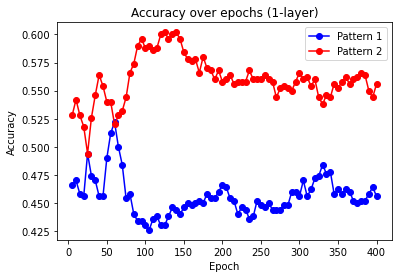

In [54]:
import matplotlib.pyplot as plt

epoch_intervals = range(5, 5 * (len(acc_a_list[:80]) + 1), 5) 

plt.plot(epoch_intervals, acc_a_list[:80], label='Pattern 1', color='blue', marker='o') # 'marker' adds a marker at each data point
plt.plot(epoch_intervals, acc_b_list[:80], label='Pattern 2', color='red', marker='o') # 'marker' adds a marker at each data point

# Adding legend to the plot
plt.legend()

# Title and labels
plt.title('Accuracy over epochs (1-layer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


# Show the plot on the screen
plt.show()